## Final Project Submission

Please fill out:
* Student name: Jessica Forrest-Baldini
* Student pace: Part-time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


## Import Packages & Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
from datetime import datetime as date
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv('kc_house_data.csv') 
df = pd.DataFrame(data)
#df.head()

## Clean Data

In [2]:
# Drop yr_renovated - only 744 homes renovated
# Drop waterfront - only 146 homes with waterfronts
# Drop view - this represent if the property has been viewed
# Drop id

to_drop = ['yr_renovated','waterfront','view','id']
df = df.drop(to_drop, axis=1)

In [3]:
# Replace NaN basement values with 0 as there are only 454 of them 
# Test median values for these later to see if it improves model

df.sqft_basement = df.sqft_basement.replace('?','0.0').astype(float)
#df.sqft_basement = df.sqft_basement+1

In [4]:
# Take abs of longitude for normalization later on
df.long = abs(df.long)

8317


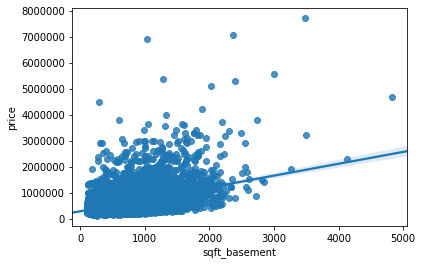

In [5]:
#print(df.sqft_basement.describe())
#df.sqft_basement.value_counts()
#df[df.sqft_basement > 100].sort_values(by='sqft_basement', ascending=True).head(20)
print(sum(df.sqft_basement > 0))
#sns.regplot(df.sqft_basement,df.price);
sns.regplot(df[df.sqft_basement >= 110].sqft_basement,df[df.sqft_basement >= 110].price);

Only 8,317 of the 32,000+ homes have basements, so we're going to bin them. I used zero as one bin and then did a quartile split for all the 'sqft_basement' values for homes with basements. 

In [6]:
# # Bin 'sqft_basement' starting at the min square footage for homes with a basement
# bins = pd.qcut(df.sqft_basement[df.sqft_basement >= 110],q=4)
# bins.value_counts()

In [7]:
# Bin sqft_basement

bins_sqft_basement = [0,109,450,980,5000]

# Bin data & return dummies
def binned_dummies(data, features, bins):
    data_bins = pd.cut(data, bins)
    data_bins = data_bins.cat.as_unordered()
    dummies = pd.get_dummies(data_bins, prefix = features, drop_first=True)
    return dummies

dummies_sqft_basement = binned_dummies(df.sqft_basement,'sqft_basement', bins_sqft_basement)

# Remove original column from data set
df = df.drop(['sqft_basement'], axis=1)
                                            
# Add new columns in
df = pd.concat([df, dummies_sqft_basement], axis=1)

In [8]:
# plt.hist(df.grade);

In [9]:
# plt.hist(df.condition);

In [10]:
# df.condition.describe()

In [11]:
# plt.hist(df.long);

In [12]:
# Define function to convert datestr to datenum
def datenum(datestr):
    '''
    Convert datestring in the format MM/DD/YYYY
    to MATLAB style datenum
    '''
    datenum = date.toordinal(date((int(datestr.split('/', -1)[2])),
                                  (int(datestr.split('/', -1)[0])),
                                  (int(datestr.split('/', -1)[1]))
                                 ))+366
    return datenum

# Apply to date column
df.date = df.date.map(datenum)

Explore the data and check for any outliers.

In [13]:
# round(df.describe(),1)

We can see here that bedrooms has what seems to be a major outlier, 33 bedrooms. Let's take a deeper look. 

In [14]:
# # Compare with other homes in data set that have high number of bedrooms
# df[df.bedrooms > 9] 

In [15]:
# 33 bedrooms and only 1.75 bathrooms doesn't seem right. It is a pretty big lot at 6,000sqft
# but 33 bedrooms doesn't seem right. Remove. 

to_drop = df[df.bedrooms == 33].index
df = df.drop(to_drop)

'sqft_lot' seems to have a major outlier at 1,651,359 sqft. Let's take a closer look.

In [16]:
# print(df.sqft_lot.median())
# display(df.sort_values(by='sqft_lot', ascending=False).head(5))

This appears to be the highest, but not necessarily an outlier. Let's go ahead and leave it for now. 

In [17]:
# df.long.describe()

In [18]:
# plt.hist(df.long);

## Normalize, MinMax Scale, Standardize, 
One-Hot Encode

First, check for normality, heteroscedasticity & discover categorical data. Can get a good idea of categorical features from looking at the data above, but let's explore normality, categorical and any relationships using a pairplot.

In [19]:
# Commented out because takes a long time to run
#sns.pairplot(df)

While 'condition' and 'grade' are technically categorical, they are on a scale, so I am going to leave them as is, and will min-max scale them. 

In [20]:
# features = ['date','price','sqft_living', 'bedrooms','bathrooms',
#             'lat','long','floors','condition','grade','sqft_living',
#             'sqft_lot','sqft_above','yr_built',
#             'sqft_living15','sqft_lot15','zipcode']

In [21]:
# Normalize Data

# Log Transform 

# Continuous variables
features = ['date','price','sqft_living', #'sqft_basement',
            'sqft_lot','sqft_above','yr_built',
            'sqft_living15','sqft_lot15','zipcode']

df_cont_features = df[features]

# Add '_log' to continuous variable column names
log_names = [f'{column}_log' for column in df_cont_features.columns]

# Log transform continuous variables
df_log = np.log(df_cont_features)
df_log.columns = log_names


### Normalize (subract mean and divide by std)

# Define function to normalize
def normalize(feature):
    return (feature - feature.mean()) / feature.std()

# Apply function to normalize
df_log_norm = df_log.apply(normalize)

# # Define function to min-max scale
# def minmaxscale(feature):
#     return (feature-min(feature))/(max(feature)-min(feature))

# # Apply function to min-max scale
# df_log_norm_scale = df_log.apply(minmaxscale)

# Remove original column from data set
df = df.drop(features, axis=1)

# Add new columns in
df = pd.concat([df, df_log_norm], axis=1) #_scale

In [22]:
# df.head()

## Check for Multicollinearity 

### Multicollinearity

In [23]:
# Take a look at the correlation matrix to check for multicollinearity
abs(df.corr()) > 0.75

,bedrooms,bathrooms,floors,condition,grade,lat,long,"sqft_basement_(109, 450]","sqft_basement_(450, 980]","sqft_basement_(980, 5000]",date_log,price_log,sqft_living_log,sqft_lot_log,sqft_above_log,yr_built_log,sqft_living15_log,sqft_lot15_log,zipcode_log
bedrooms,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
bathrooms,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
floors,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
condition,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
grade,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
lat,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
long,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
"sqft_basement_(109, 450]",False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
"sqft_basement_(450, 980]",False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
"sqft_basement_(980, 5000]",False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False


In [24]:
# # Check & see if sqft_lot15 & sqft_living15 are correlated with sqft_lot & sqft_living
# sns.regplot(df.sqft_lot,df.sqft_lot15)
# plt.show()
# sns.regplot(df.sqft_living,df.sqft_living15)
# plt.show()

We can see that 'sqft_lot15' & 'sqft_living15' are correlated with 'sqft_lot' & 'sqft_living', which makes sense because the features appended with 15 represent the average of the 15 nearest neighbors. 

We will remove these values to prevent multicollinearity in our model. 

In [25]:
# # Remove sqft_lot15 & sqft_living15
# df = df.drop(['sqft_lot15','sqft_living15'], axis=1)

In [26]:
# # Take a look at the correlation matrix to check for multicollinearity
# df.corr() > 0.75

We can see here that 'sqft_living' seems to be highly correlated with multiple features such as 'bathrooms', 'grade', and 'sqft_above'. 'sqft_living' represents the square footage of the entire home and seems that it would be a strong indicator of home price. The squarefoot of other features are essentially subsets of the overall home squarefootage. So for now I am going to remove it. However, it could be kept in place and other features removed later on to see if this improves the overall performance of the model.

In [27]:
# # Remove 'sqft_living' to prevent multicollinearity 
# # as it is highly correlated with multiple features

# df = df.drop(['sqft_living'], axis=1)

In [28]:
# abs(df.corr()) > 0.75

It looks like 'sqft_above' and 'grade' are highly correlated, so we should only keep one to prevent multicollinearity. 

For now I'm going to keep 'sqft_above', but can also test removing 'sqft_above' and one-hot-encoding 'grade' later on to see if it improves performance of the model. 

In [29]:
# # We can see the relationship here between 'sqft_above' and 'grade', it appears to possibly
# # be polynomial. While grade is categorical, it is continuous
# sns.regplot(df.grade,df.sqft_above);

Since the relationship looks slightly polynomial, and 'grade' technically is categorical, I want to look at their distributions to further explore the relationship. Let's look at the histograms/distplot.

In [30]:
# sns.distplot(df.sqft_above)
# plt.show()
# plt.hist(df.grade)
# plt.show()

Both do appear to be skewed in the same direction, so perhaps they are linearly related. Okay, I will remove grade. 

In [31]:
# df = df.drop(['grade'], axis=1)

In [32]:
# df.head()

## Start Modeling

### Split train/test datasets

In [33]:
# Separate target and feature variables

X = df.drop(['price_log'],axis=1)
y = df.price_log

In [34]:
# Import train_test_split from sklearn
from sklearn.model_selection import train_test_split

# Split data with test size of 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

### Fit Model

In [35]:
from sklearn.linear_model import LinearRegression

# Initialize the linear regression model class
linreg = LinearRegression()

# Fit the model to train data
linreg.fit(X_train, y_train)

# Calculate predictions on test set
y_hat_test = linreg.predict(X_test)

### Cross Validate Model

In [36]:
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import cross_val_score

mse = make_scorer(mean_squared_error)

# Test Errors Results
cv_5_results = cross_val_score(linreg, X, y, cv=5, scoring=mse)
cv_5_results


print(f"RMSE: {np.sqrt(cv_5_results.mean())}")

RMSE: 0.4928900917140485


In [37]:
from sklearn.model_selection import KFold

crossval = KFold(n_splits=3, shuffle=True, random_state=1)

baseline_R2 = np.mean(cross_val_score(linreg, X, y, scoring='r2', cv=crossval))
baseline_R2

0.7584191469177276

### Statsmodel (OLS)

In [38]:
import statsmodels.api as sm
X = sm.add_constant(X)
model = sm.OLS(y,X)
results = model.fit()

results.summary()

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     3785.
Date:                Mon, 11 May 2020   Prob (F-statistic):               0.00
Time:                        17:10:20   Log-Likelihood:                -15257.
No. Observations:               21596   AIC:                         3.055e+04
Df Residuals:                   21577   BIC:                         3.070e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                      -154.4819      4.270    -36.175      0.000    -162.852    -146.112
bedrooms                     -0.0738      0.005    -14.738      0.000      -0.084      -0.064
bathrooms                     0.1508      0.008     19.220      0.000       0.135       0.166
floors                        0.1079      0.010     11.233      0.000       0.089       0.127
condition                     0.1153      0.006     20.303      0.000       0.104       0.126
grade                         0.3303      0.005     65.120      0.000       0.320       0.340
lat                           2.5241      0.026     96.303      0.000       2.473       2.575
long                          0.2554      0.033      7.848      0.000       0.192       0.319
sqft_basement_(109, 450]      0.1604      0.015     10.827      0.000       0.131       0.189
sqft_basement_(450, 980]      0.1288      0.019      6.609      0.000       0.091       0.167
sqft_basement_(980, 5000]     0.2548      0.026      9.621      0.000       0.203       0.307
date_log                      0.0431      0.003     12.854      0.000       0.036       0.050
sqft_living_log               0.1451      0.019      7.625      0.000       0.108       0.182
sqft_lot_log                  0.0295      0.009      3.342      0.001       0.012       0.047
sqft_above_log                0.1311      0.018      7.263      0.000       0.096       0.167
yr_built_log                 -0.2405      0.005    -49.260      0.000      -0.250      -0.231
sqft_living15_log             0.1518      0.006     27.136      0.000       0.141       0.163
sqft_lot15_log               -0.0520      0.009     -6.044      0.000      -0.069      -0.035
zipcode_log                  -0.0506      0.004    -11.771      0.000      -0.059      -0.042
==============================================================================
Omnibus:                      504.430   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              905.245
Skew:                           0.190   Prob(JB):                    2.68e-197
Kurtosis:                       3.929   Cond. No.                     1.68e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.68e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Interactions

In [39]:
from itertools import combinations

# Find top interactions by R^2 value

# Use combinations from itertools to create all possible combinations of two features
feat_combinations = combinations(X_train.columns, 2)

# Empty list to fill for interactons values
interactions = []

# for i, (feature1,feature2) in feature_combinations:
for i, (a, b) in enumerate(feat_combinations):
    # fill interatctions list with feature a * feature b
    X_train['interaction'] = X_train[a] * X_train[b]
    R2 = np.mean(cross_val_score(linreg, X_train, y_train, scoring='r2', cv=crossval))
    if R2 > baseline_R2:
        interactions.append((a, b, round(R2,5)))
            
print('Top 3 interactions: %s' %sorted(interactions, key=lambda inter: inter[2], reverse=True)[:3])

Top 3 interactions: [('lat', 'sqft_lot15_log', 0.7683), ('lat', 'sqft_lot_log', 0.76806), ('long', 'zipcode_log', 0.7665)]


# Best Performing Model - So Far

In [40]:
#Build a final model with interactions
#Use 10-fold cross-validation to build a model using the above interaction.

crossval = KFold(n_splits=10, shuffle=True, random_state=1)
final = X.copy()

final['lat*sqft_lot15_log'] = final['lat'] * final['sqft_lot15_log']
final['lat*sqft_lot_log'] = final['lat'] * final['sqft_lot_log']
final['long*zipcode_log'] = final['long'] * final['zipcode_log']

final['lat*long'] = final['lat'] * final['long']

final_model_R2 = np.mean(cross_val_score(linreg, final, y, scoring='r2', cv=crossval))

print(final_model_R2)

import statsmodels.api as sm
df_inter_sm = sm.add_constant(final)
model = sm.OLS(y,final)
results = model.fit()

results.summary()

0.7712689962168888


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                     3325.
Date:                Mon, 11 May 2020   Prob (F-statistic):               0.00
Time:                        17:10:26   Log-Likelihood:                -14668.
No. Observations:               21596   AIC:                         2.938e+04
Df Residuals:                   21573   BIC:                         2.957e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                      1.079e+04   1173.765      9.190      0.000    8485.931    1.31e+04
bedrooms                     -0.0649      0.005    -13.297      0.000      -0.075      -0.055
bathrooms                     0.1440      0.008     18.854      0.000       0.129       0.159
floors                        0.0550      0.010      5.776      0.000       0.036       0.074
condition                     0.1053      0.006     19.008      0.000       0.094       0.116
grade                         0.3210      0.005     64.921      0.000       0.311       0.331
lat                        -228.4282     24.693     -9.251      0.000    -276.829    -180.028
long                        -89.3142      9.605     -9.299      0.000    -108.140     -70.488
sqft_basement_(109, 450]      0.1371      0.014      9.501      0.000       0.109       0.165
sqft_basement_(450, 980]      0.1145      0.019      6.034      0.000       0.077       0.152
sqft_basement_(980, 5000]     0.2216      0.026      8.589      0.000       0.171       0.272
date_log                      0.0430      0.003     13.186      0.000       0.037       0.049
sqft_living_log               0.1470      0.019      7.938      0.000       0.111       0.183
sqft_lot_log                  7.9474      2.857      2.782      0.005       2.348      13.547
sqft_above_log                0.1488      0.018      8.458      0.000       0.114       0.183
yr_built_log                 -0.2257      0.005    -47.175      0.000      -0.235      -0.216
sqft_living15_log             0.1728      0.005     31.492      0.000       0.162       0.184
sqft_lot15_log               17.1696      2.846      6.032      0.000      11.591      22.749
zipcode_log                 -94.1553      5.119    -18.395      0.000    -104.188     -84.122
lat*sqft_lot15_log           -0.3623      0.060     -6.052      0.000      -0.480      -0.245
lat*sqft_lot_log             -0.1666      0.060     -2.773      0.006      -0.284      -0.049
long*zipcode_log              0.7695      0.042     18.382      0.000       0.687       0.852
lat*long                      1.8907      0.202      9.357      0.000       1.495       2.287
==============================================================================
Omnibus:                      599.029   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1250.630
Skew:                           0.173   Prob(JB):                    2.69e-272
Kurtosis:                       4.127   Cond. No.                     2.10e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.1e+09. This might indicat

In [41]:
# Test Errors Results
cv_5_results = cross_val_score(linreg, final, y, cv=5, scoring=mse)
cv_5_results


print(f"RMSE: {np.sqrt(cv_5_results.mean())}")

RMSE: 0.47950809862285115


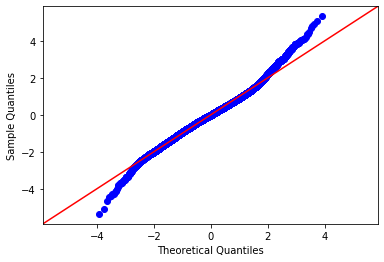

In [42]:
fig = sm.graphics.qqplot(results.resid, dist=stats.norm, line='45', fit=True)